<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [3]:
!vw --version

8.3.2


##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [214]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=10**-3, n_iter=10):
        self.eta = eta
        self.n_iter= n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X_pad = np.vstack([np.ones_like(X), X]).T
        w = np.zeros((X_pad.shape[1],1)).T
        
        for i in xrange(self.n_iter):
            for item_num in xrange(X.shape[0]):
                w_old = w
                w_new = w.copy()
                w_new[0][0] = w_old[0][0] + self.eta*(y[item_num] - w_old.dot(X_pad[item_num].T))
                w_new[0][1] = w_old[0][1] + self.eta*(y[item_num] - w_old.dot(X_pad[item_num].T))*X_pad[item_num,1]
                w = w_new
                self.weights_.append(w)
                
                y_pred = w.dot(X_pad.T)
                y_pred = y_pred.reshape(X.shape)
                loss = mean_squared_error(y_pred, y)
                self.mse_.append(loss)
                
        self.w_ = w
        
        return self
    
    
    def predict(self, X):
        X_pad = np.vstack([np.ones_like(X), X]).T
        y_pred = self.w_.dot(X_pad.T)
        y_pred = y_pred.reshape(X.shape)
        return y_pred

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [197]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

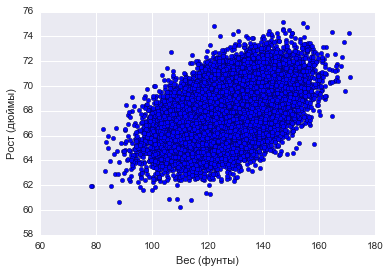

In [198]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel(u'Вес (фунты)')
plt.ylabel(u'Рост (дюймы)');

In [199]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [200]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [201]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [218]:
%%time
sgd_my = SGDRegressor()
sgd_my.fit(X_train_scaled.reshape(X_train_scaled.shape[0]), y_train)

CPU times: user 1min 14s, sys: 7.44 s, total: 1min 21s
Wall time: 1min 23s


Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

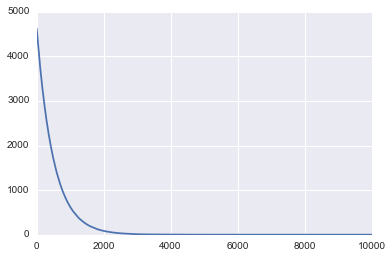

In [221]:
plt.plot(sgd_my.mse_[:10000])

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [222]:
sgd_my.mse_[-1]

2.718653085963437

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

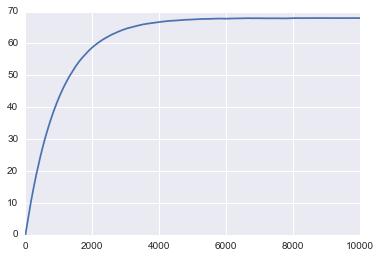

In [230]:
plt.plot(map(lambda x:x[0][0], sgd_my.weights_[:10000]))

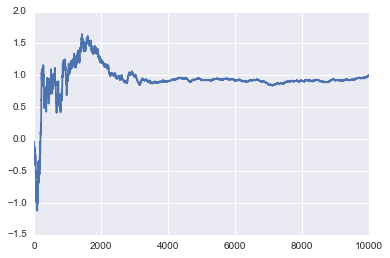

In [231]:
plt.plot(map(lambda x:x[0][1], sgd_my.weights_[:10000]))

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [233]:
y_pred = sgd_my.predict(X_valid_scaled.reshape(X_valid_scaled.shape[0]))
print mean_squared_error(y_pred, y_valid)

2.6758568913


Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [234]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train_scaled,y_train)
y_pred1 = linreg.predict(X_valid_scaled)
print mean_squared_error(y_pred1, y_valid)

2.67083076767


<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [294]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [596]:
class SGDClassifier(BaseEstimator):
    def __init__(self, eta=10**-3, n_iter=10, C=1):
        self.eta = eta
        self.n_iter= n_iter
        self.C = C
        self.loss = []
        self.weights_ = []
        
    def fit(self, X, y):
        X_pad = np.hstack([np.ones((X.shape[0],1)), X])
        y = np.array([i if i == 1 else 0 for i in y])
        w = np.zeros((X_pad.shape[1],1)).T
        
        for iter_num in xrange(self.n_iter):
            for i in xrange(X.shape[0]):
                w_old = w
                w_new = w.copy()
                for j in xrange(w.shape[1]):
                    w_new[0][j] = w_old[0][j] + self.eta*(self.C*y[i]*X_pad[i,j]*sigma(-y[i]*w.dot(X_pad[i].T)) \
                                                          - ind(j)*w_old[0][j])
                
                w = w_new
                self.weights_.append(w)
                
                y_pred = sigma(w.dot(X_pad.T))
                loss = self.C*np.log(1 + np.exp(-y*np.dot(X_pad,w.T))).mean() + 1/2.0*np.sum(w*w)
                self.loss.append(loss)
                
        self.w_ = w
        
        return self
    
    
    def predict_proba(self, X):
        X_pad = np.hstack([np.ones((X.shape[0],1)), X])
        y_pred = sigma(self.w_.dot(X_pad.T))
        return y_pred
    
    def predict(self, X):
        y_pred = self.predict_proba(X)
        pred_labels = [1 if i >= 0.5 else -1 for i in y_pred]
        return pred_labels
                  

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [597]:
from sklearn.datasets import load_breast_cancer

In [598]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [599]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [600]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [601]:
sgd_clf = SGDClassifier(eta=10**-3, n_iter=3, C=1)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

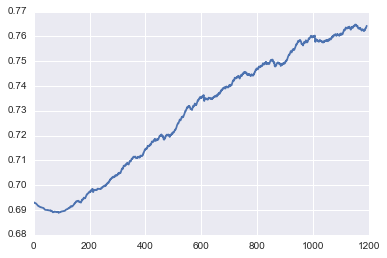

In [602]:
plt.plot(sgd_clf.loss)

In [603]:
y_pred = sgd_clf.predict_proba(X_valid_scaled)
y_pred[:10]

array([ 0.66316769,  0.73952269,  0.7606712 ,  0.73632161,  0.8065538 ,
        0.72449124,  0.75954177,  0.20051652,  0.61547196,  0.37572947])

In [604]:
y_valid[:10]

[1, 1, 1, 1, 1, 1, 1, -1, 1, -1]

In [605]:
sgd_clf.predict(X_valid_scaled)[:10]

[1, 1, 1, 1, 1, 1, 1, -1, 1, -1]

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [606]:
sgd_clf = SGDClassifier(eta=10**-3, n_iter=10, C=1000)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(C=1000, eta=0.001, n_iter=10)

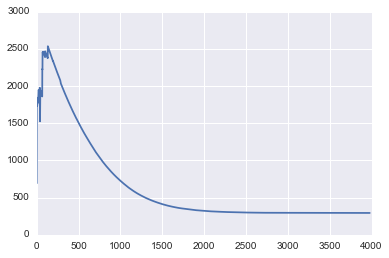

In [607]:
plt.plot(sgd_clf.loss)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

In [608]:
print sgd_clf.w_.shape
print X.shape

(1, 31)
(569, 30)


In [609]:
max_index = sgd_clf.w_[0][1:].argmax()

In [610]:
sgd_clf.w_[0][1:][max_index]

0.023071799626846096

In [611]:
cancer.feature_names[max_index]

'concavity error'

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [619]:
y_pred_mine = sgd_clf.predict_proba(X_valid_scaled)
print roc_auc_score(y_valid, y_pred_mine)

0.98912071535


In [618]:
from sklearn.linear_model import LogisticRegression 
logreg = LogisticRegression(random_state=17)
logreg.fit(X_train_scaled, y_train)
logreg_pred = logreg.predict_proba(X_valid_scaled)
print roc_auc_score(y_valid, logreg_pred[:,1])

0.989269746647


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [623]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [624]:
reviews_train = load_files("../../data/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [625]:
reviews_test = load_files("../../data/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [626]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 1min 21s, sys: 2.58 s, total: 1min 23s
Wall time: 1min 26s


In [23]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [629]:
%%time
logreg = LogisticRegression(random_state=17, n_jobs=-1)
logreg.fit(X_train, y_train)

CPU times: user 1min 10s, sys: 1.56 s, total: 1min 12s
Wall time: 1min 18s


In [633]:
y_pred = logreg.predict_proba(X_test)
print roc_auc_score(y_test, y_pred[:,1])

0.95825232


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [634]:
from sklearn.linear_model import SGDClassifier

In [638]:
%%time
sgd_logreg = SGDClassifier(loss="log", random_state=17, n_jobs=-1, n_iter=100)
sgd_logreg.fit(X_train, y_train)

CPU times: user 12.8 s, sys: 237 ms, total: 13.1 s
Wall time: 14.1 s


In [639]:
y_pred1 = sgd_logreg.predict_proba(X_test)
print roc_auc_score(y_test, y_pred1[:,1])

0.95765168


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5